In [149]:
import pm4py
import pandas as pd
import conformance_checker as cc
import process_discovery
import requests
import json
import utilities
from bot_parser import get_bot_parser
import uuid

In [150]:
def getBotInfo(endpoint="http://localhost:8080/SBFManager"):
    """
    Fetches the first bot from the social bot manager and returns its id and name
    """
    response = requests.get(f"{endpoint}/bots")
    if response.status_code == 200:
        data = json.loads(response.content)
        if len(data) == 0:
            return None
        first_value = list(data.values())[0]
        return first_value['id'], first_value['name']
    else:
        return None

In [151]:
bot_manager_endpoint = "https://mobsos.tech4comp.dbis.rwth-aachen.de/SBFManager"
# bot_manager_endpoint = "http://localhost:8080/SBFManager"
bot_id, bot_name = getBotInfo(bot_manager_endpoint)

event_log_generator_endpoint = "https://mobsos.tech4comp.dbis.rwth-aachen.de/event-log"
# event_log_generator_endpoint = "http://localhost:8087"

log = utilities.fetch_event_log(bot_name, event_log_generator_endpoint)
if log is None:
    raise ValueError("Event log not found")

log.head()

Fetching event log from https://mobsos.tech4comp.dbis.rwth-aachen.de/event-log/bot/MensaBot
















parsing log, completed traces :: 100%|██████████| 3/3 [00:00<00:00, 1102.89it/s]
/Users/lakhoune/Desktop/Repos/process-mining-for-bots/.venv/lib/python3.11/site-packages/pm4py/utils.py:499: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


,EVENT,REMARKS,RESOURCE,RESOURCE_TYPE,concept:name,in-service-context,lifecycle:transition,serviceEndpoint,time:timestamp,user,case:concept:name
1,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,greeting,False,complete,NaN,2023-08-31 15:35:28+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,3e4ce245-f23d-443a-ad54-15a8f2e3fe32
5,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,menu,False,complete,NaN,2023-08-31 15:35:33+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,0070fe95-1be8-4c7e-bfab-e660b84396f4
9,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,getMenu,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,2023-08-31 15:35:34+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,0070fe95-1be8-4c7e-bfab-e660b84396f4
11,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,number_selection,True,complete,NaN,2023-08-31 15:35:38+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,0070fe95-1be8-4c7e-bfab-e660b84396f4
13,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",28d2024790065ba320fd009ac8c575864e7670e5e4adee...,bot,getMenu,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,2023-08-31 15:35:38+00:00,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...,0070fe95-1be8-4c7e-bfab-e660b84396f4


# Discovered Model

In [152]:
traces = pm4py.get_variants(log)
traces

{('menu',
  'getMenu',
  'number_selection',
  'getMenu',
  'confirmation',
  'getMenu'): 1,
 ('greeting',): 1,
 ('help',): 1}

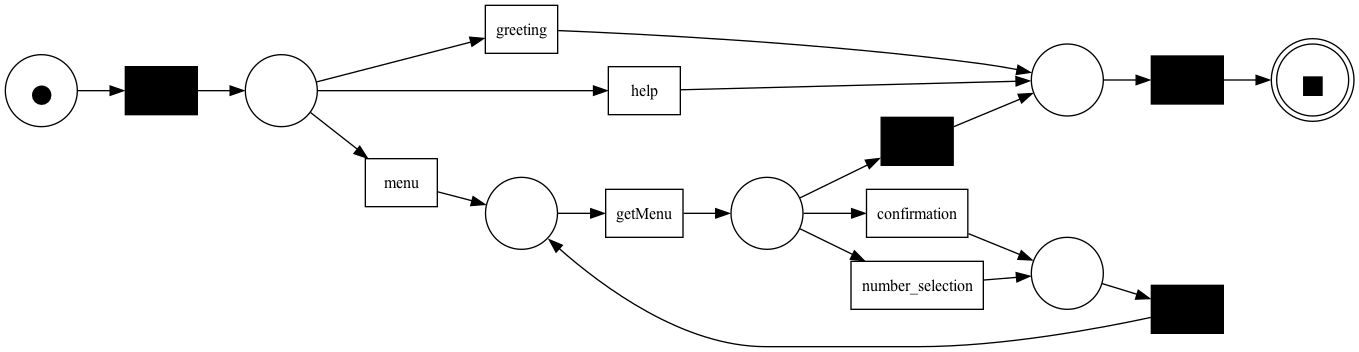

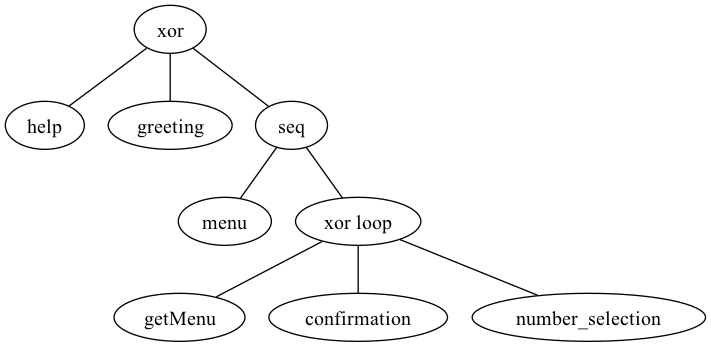

In [153]:
log = pm4py.filter_variants_top_k(log, 10)

net,im,fm = process_discovery.discover_petri_net(log)
pm4py.view_petri_net(net,im,fm)
process_tree = process_discovery.discover_process_tree(log)
pm4py.view_process_tree(process_tree)
# bpmn = process_discovery.discover_bpmn(log)
# pm4py.view_bpmn(bpmn)

In [154]:
traces = pm4py.get_variants(log)
traces

{('menu',
  'getMenu',
  'number_selection',
  'getMenu',
  'confirmation',
  'getMenu'): 1,
 ('greeting',): 1,
 ('help',): 1}

# Bot Model

Fetching bot model from https://mobsos.tech4comp.dbis.rwth-aachen.de/SBFManager/models/MensaBot


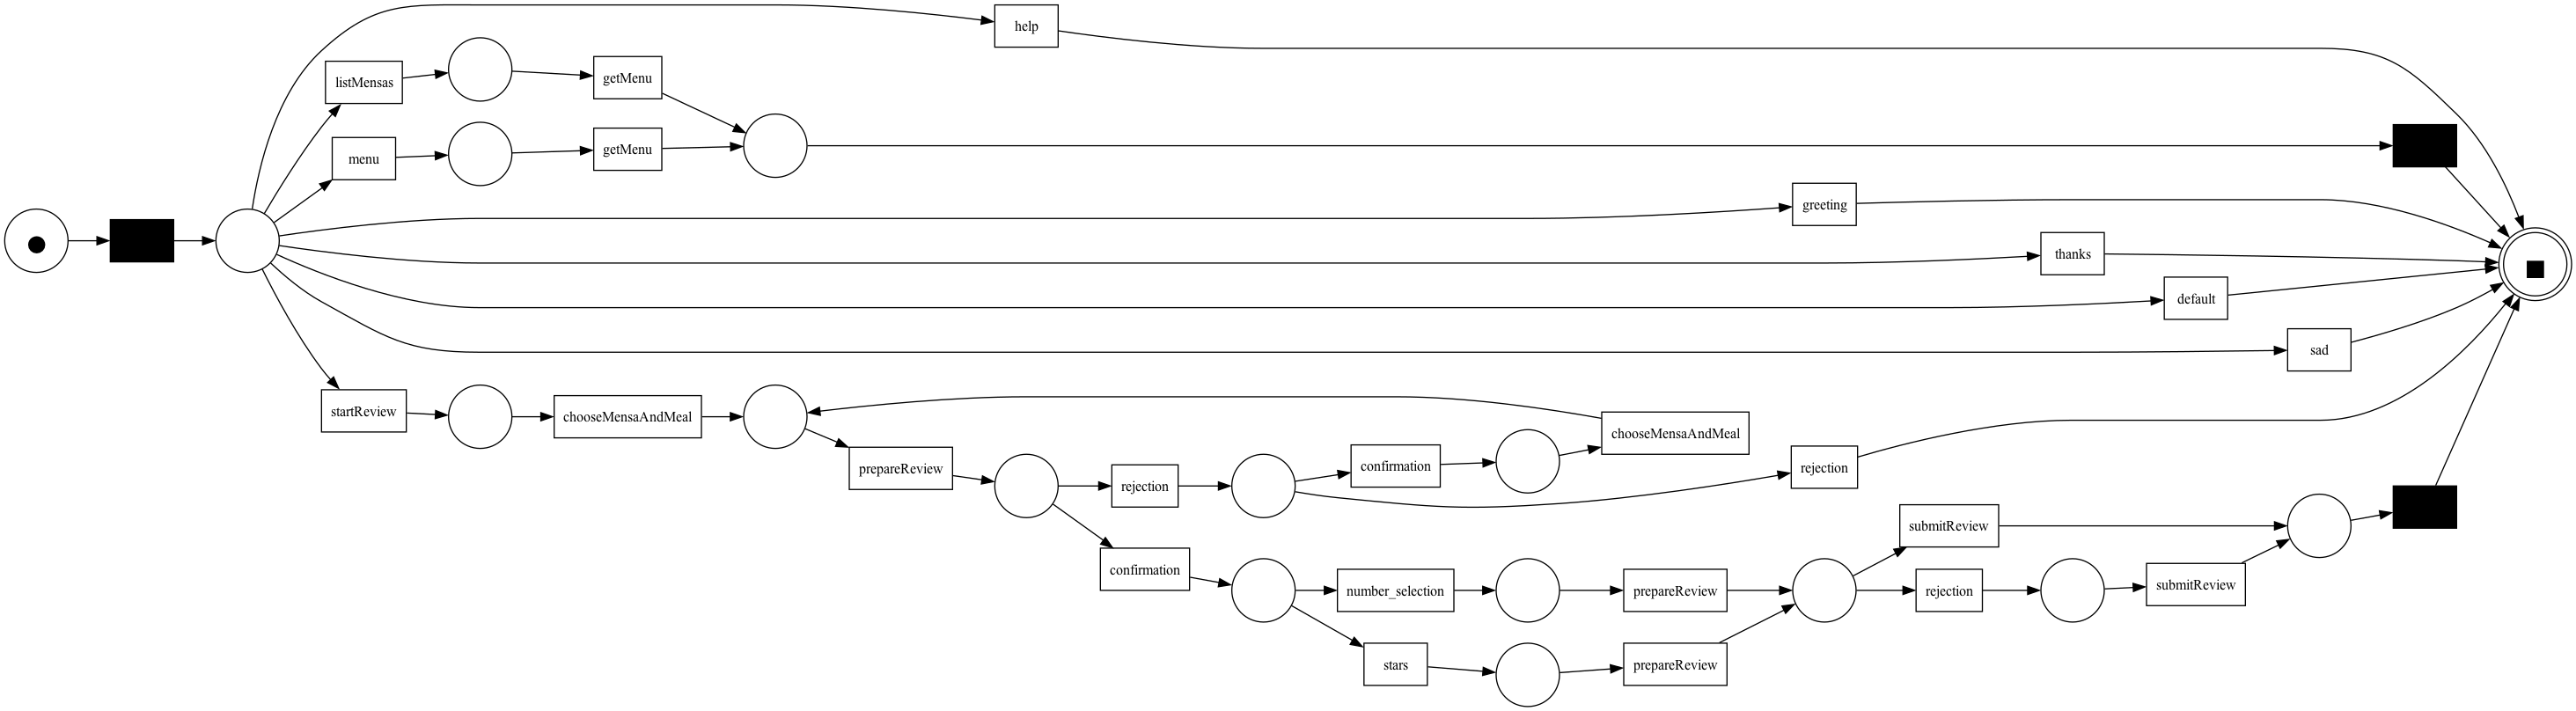

In [155]:
model = utilities.fetch_bot_model(bot_name,bot_manager_endpoint)
bp = get_bot_parser(model)
bot_net,bot_im,bot_fm= bp.to_petri_net()
dfg,start_activities,end_activities = bp.to_dfg()
bot_net=pm4py.reduce_petri_net_invisibles(bot_net)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)


In [156]:
unfitting_traces = cc.find_unfitting_traces(log, bot_net, bot_im, bot_fm)
missing_log_moves = list()
for trace in unfitting_traces:
    for move in trace['alignment']:
        if move[0] == ">>" and move[1]!= None:
            missing_log_moves.append(move[1])


TypeError: 'function' object is not subscriptable

In [ ]:

print(f"Missing log moves: {missing_log_moves}")

Move on log: getMenu

Move on log: number_selection

Move on log: greeting



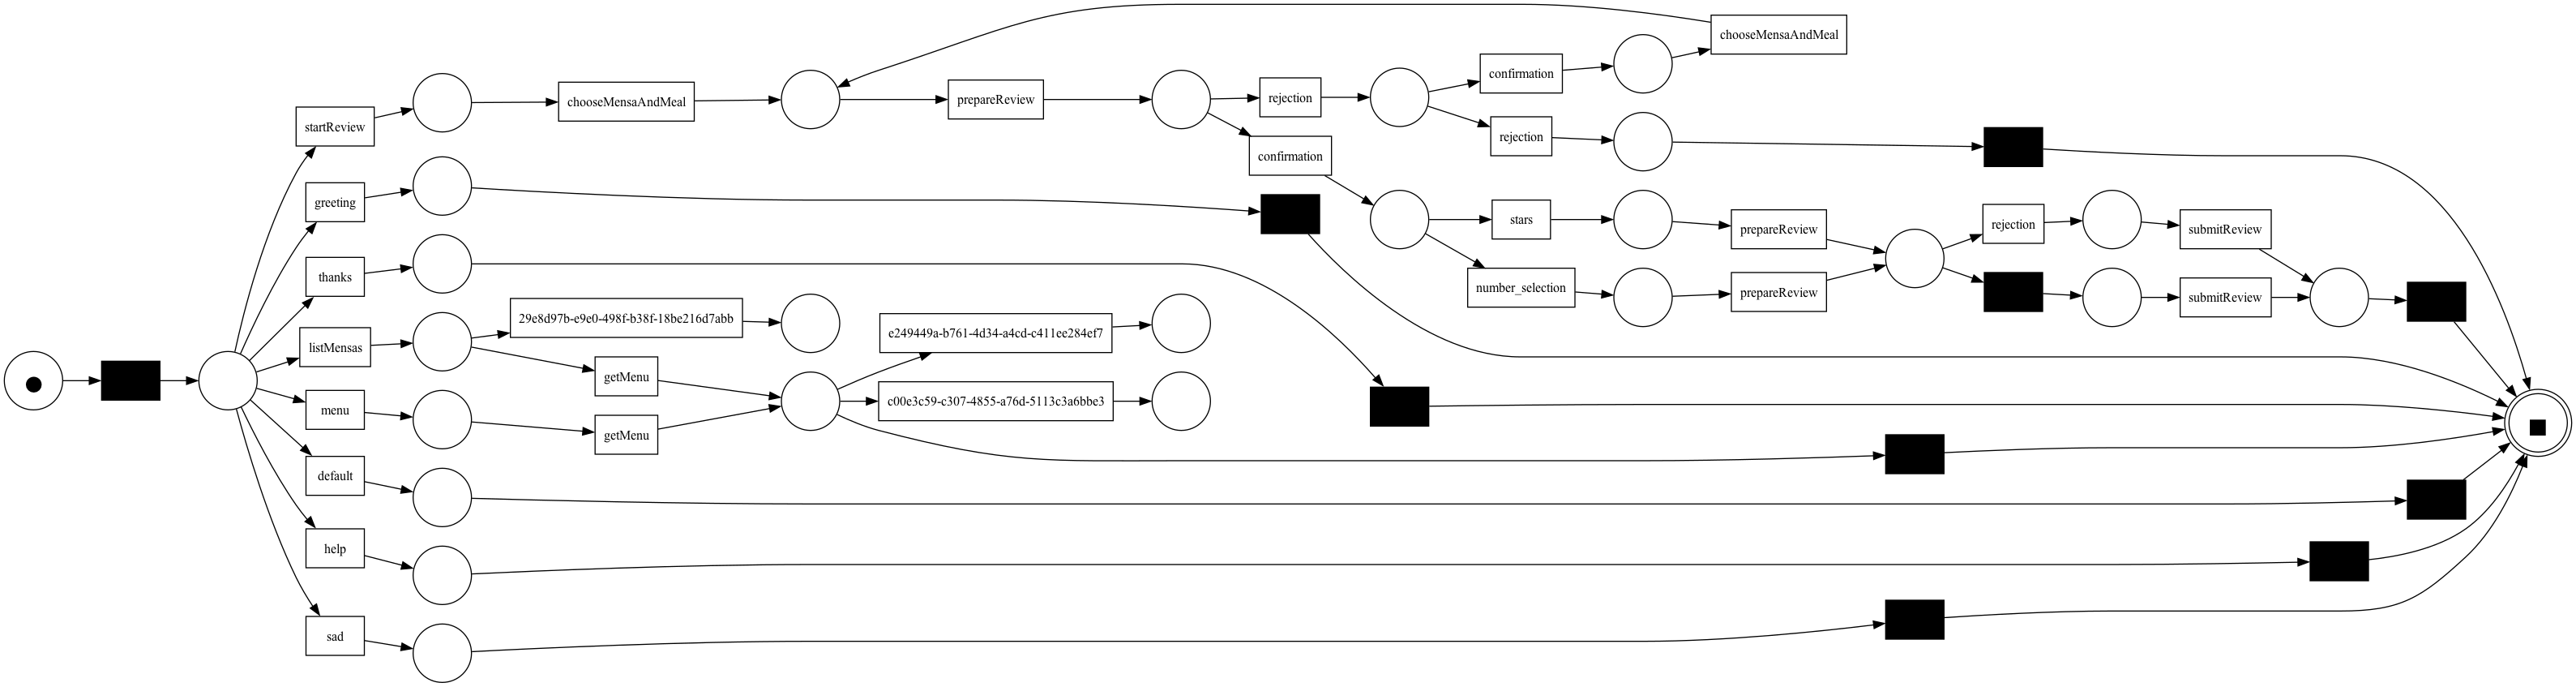

In [ ]:
start_id = start_activities.copy().pop()

for diagnostic in unfitting_traces:
    prev_activity = None
    alignment = diagnostic['alignment']
    # iterate over the alignment and find the missing log moves
    for step in alignment:
        if step[1] ==">>":
            print("Move on log: "+step[0]+"\n")
            # in this case the activity is not present in the bot model, we adjust the dfg to make it fit
            # generate a new id for the activity using uuid
            new_activity_id = str(uuid.uuid4())
            if(prev_activity is not None):
                dfg[(prev_activity,new_activity_id)] = 1
            else:
                dfg[(start_id,new_activity_id)] = 1
            


        prev_activity = bp.get_node_id_by_name( step[0])


bot_net,bot_im,bot_fm=bp.to_petri_net(dfg,start_activities,end_activities)
pm4py.view_petri_net(bot_net,bot_im,bot_fm)